# Compute Slopes

A quick demo at looking how to compute slopes on a grid of CMIP6 output. This uses vectorized operations via `apply_ufunc` to avoid nesting for-loops (O(N$^{2}$)) so it can be applied to the grid all at once. The same machinery works for something in-memory (e.g. a single model run) or for dask (e.g. an ensemble run).

In [1]:
%matplotlib inline
import intake
import xarray as xr
import numpy as np

Slope computation function -- simple linear slope computed at each grid cell without accounting for p-value significance.

In [2]:
def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

Ingest datastore with `intake-esm`.

In [3]:
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")

## (1) Compute slope in-memory for a single ensemble member.

In [5]:
# Just select CESM2 here for a single ensemble member.
cat = col.search(member_id='r1i1p1f1',
                 experiment_id='historical',
                 activity_id='CMIP',
                 table_id='Omon',
                 variable_id='spco2',
                 grid_label='gn',
                 source_id='CESM2')

In [6]:
# Chunk over the full time dimension since we're computing slope over the time dimension.
dsets = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": -1}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'spco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [7]:
ds = dsets['CMIP.NCAR.CESM2.historical.Omon.gn'].squeeze()

In [8]:
single_member = ds['spco2'].load() # Load the single member INTO MEMORY.

This took ~56.3s in memory to compute. Nesting for-loops to hit each grid cell would be on the order
of tens of minutes, which I don't want to run. **Don't double nest for-loops.**

In [9]:
%%time
slopes = compute_slope(single_member)

CPU times: user 53.1 s, sys: 402 ms, total: 53.5 s
Wall time: 56.3 s


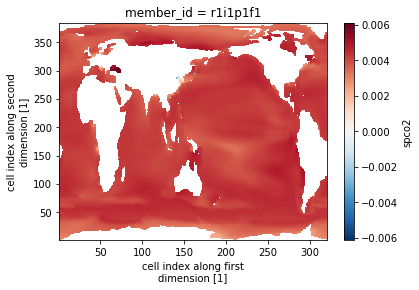

In [10]:
slopes.plot()

## (2) Using dask out-of-memory for a full ensemble of 11 members.

Now we'll do the same to compute slopes for each of 11 ensemble members all in parallel.

In [11]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

In [12]:
cluster = NCARCluster(cores=36, memory="100GB", walltime="00:30:00", processes=36) # Change this to SLURMCluster if on DAV/Casper
# Should use .adapt() but I'm getting a huge amount of errors/warnings with my custom
# conda environment. Use e.g. cluster.adapt(minimum=36*1, maximum=36*10) if it works.
cluster.scale(36*4) 

In [13]:
client = Client(cluster)

In [14]:
client

Client Scheduler: tcp://10.148.10.15:40781 Dashboard: https://jupyterhub.ucar.edu/ch/user/rbrady/proxy/8787/status,Cluster Workers: 144 Cores: 144 Memory: 400.32 GB


In [15]:
# Now take every CESM2 ensemble member.
cat = col.search(# member_id='r1i1p1f1',
                 experiment_id='historical',
                 activity_id='CMIP',
                 table_id='Omon',
                 variable_id='spco2',
                 grid_label='gn',
                 source_id='CESM2')

In [16]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
86946,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,spco2,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
89292,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,spco2,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
91612,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,spco2,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
93847,CMIP,NCAR,CESM2,historical,r4i1p1f1,Omon,spco2,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
96082,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,spco2,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
99465,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,spco2,gn,NaN,v20190311,200001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
99466,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,spco2,gn,NaN,v20190311,190001-194912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
99467,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,spco2,gn,NaN,v20190311,185001-189912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
99468,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,spco2,gn,NaN,v20190311,195001-199912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
104342,CMIP,NCAR,CESM2,historical,r8i1p1f1,Omon,spco2,gn,NaN,v20190311,185001-189912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...


In [17]:
# Similarly we need to chunk over the full time dimension since we're doing an application
# over the time dimension.
dsets = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": -1}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [18]:
# Now we have the full CESM2 ensemble of 11 members.
ds = dsets['CMIP.NCAR.CESM2.historical.Omon.gn']
print(ds)

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 1980, vertices: 4)
Coordinates:
  * time       (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    lat_bnds   (nlat, nlon, vertices) float32 -79.48714 -79.48714 ... 72.41355
    lat        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lon        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    lon_bnds   (nlat, nlon, vertices) float32 320.0 321.125 ... 320.0 319.586
    time_bnds  (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    spco2      (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attribu

In [19]:
# Chunking seemed to error so chunk over the full time dimension, one ensemble member
# and a 110x110 on lat/lon to get to about 100MB chunks.
ds = ds['spco2'].chunk({'time': -1, 'member_id': 1, 'nlat': 110, 'nlon': 110})

Creates chunks of ~100MB centered on full time, one ensemble member. Note that the full ensemble is 10.7GB.

In [20]:
ds.data

dask.array<rechunk-merge, shape=(11, 1980, 384, 320), dtype=float32, chunksize=(1, 1980, 110, 110), chunktype=numpy.ndarray>

In [21]:
slope = compute_slope(ds) # Sets up the dask graph to compute slope over the grid.

Note that slopes were computed for 11 ensemble members out-of-memory in <20s for the full grid!

In [22]:
%%time
slope = slope.compute()

CPU times: user 5.45 s, sys: 368 ms, total: 5.82 s
Wall time: 15.1 s


Plot each ensemble member's slopes. This is surface pCO$_{2}$ so it's a pretty robust signal.

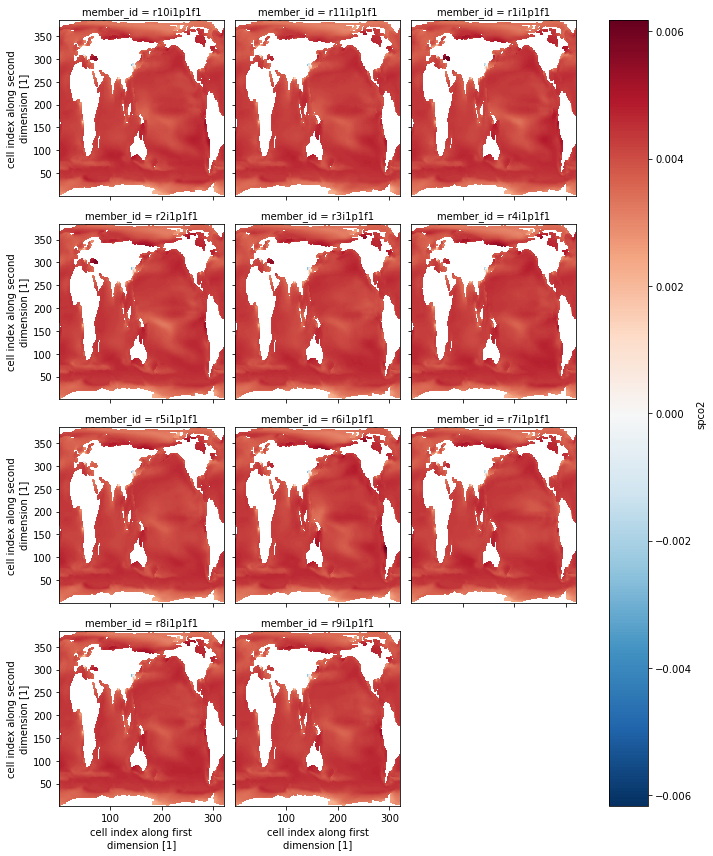

In [23]:
slope.plot(col='member_id', col_wrap=3)